# Project Description

## Overall objective

In this notebook, I want to use two state of the art Natural Language Processing (NLP) techniques which have sort of revolutionalized the area of NLP in Deep Learning.

These techniques are as follows:

1. BERT (Deep Bidirectional Transformers for Language Understanding)
2. Fastai ULMFiT (Universal Language Model Fine-tuning for Text Classification)

Both these techniques are very advanced and very recent NLP techniques (BERT was introduced by Google in 2018). Both of them incorporate the methods of Transfer Learning which is quite cool and are pre-trained on large corpuses of Wikipedia articles. I wanted to compare the overall performance of these two techniques.

I really like using Fastai for my deep learning projects and can't thank enough for this amazing community and our mentors - Jeremy & Rachael for creating few wonderful courses on the matters pertaining to Deep Learning. Therefore one of my aims to work on this project was to **integrate BERT with Fastai**. This means power of BERT combined with the simplicity of Fastai. It was not an easy task especially implementing Discriminative Learning Rate technique of Fastai in BERT modelling. 

In my project, below article helped me in understanding few of these integration techniques and I would like to extend my gratidue to the writer of this article:

[https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/](http://)



## Data

In this project, we will use Jigsaw's Toxic Comments dataset which has categorized each text item into 6 classes -

1. Toxic
2. Severe Toxic
3. Obscene
4. Threat
5. Insult
6. Identity Hate

This is a **multi-label text classification challenge**.

# Importing Libraries & Data Preparation

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

import gc
gc.collect()

0

In this section, we will import Fastai libraries and few other important libraries for our task

In [2]:
!pip install pretrainedmodels

%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install fastai==1.0.52
import fastai

from fastai import *
from fastai.vision import *
from fastai.text import *

from torchvision.models import *
import pretrainedmodels

from utils import *
import sys

from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback

     |████████████████████████████████| 61kB 2.4MB/s eta 0:00:011
  Stored in directory: /tmp/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
     |████████████████████████████████| 225kB 2.8MB/s eta 0:00:01
  Found existing installation: fastai 1.0.54
    Uninstalling fastai-1.0.54:
      Successfully uninstalled fastai-1.0.54


Let's import Huggingface's "pytorch-pretrained-bert" model (this is now renamed as pytorch-transformers)

[https://github.com/huggingface/pytorch-transformers](http://)

This is a brilliant repository of few of amazing NLP techniques and already pre-trained.

In [3]:
%%bash
pip install pytorch-pretrained-bert

BERT has several flavours when it comes to Tokenization. For our modelling purposes, we will use the most common and standard method named as "bert-case-uncased".

We will name this as bert_tok

In [4]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    "bert-base-uncased",
)

100%|██████████| 231508/231508 [00:00<00:00, 6000104.62B/s]


As mentioned in the article in first section, we will change the tokenizer of Fastai to incorporate BertTokenizer. One important thing to note here is to change the start and end of each token with [CLS] and [SEP] which is a requirement of BERT.

In [5]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

Before we move further, lets have a look at the Data on which we have to work.

We will split the train data into two parts: Train, Validation. However, for the purpose of this project, we will not be using Test Data

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
DATA_ROOT = Path("..") / "input"

train, test = [pd.read_csv(DATA_ROOT / fname) for fname in ["train.csv", "test.csv"]]
train, val = train_test_split(train, shuffle=True, test_size=0.2, random_state=42)

In [8]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
140030,ed56f082116dcbd0,Grandma Terri Should Burn in Trash \nGrandma T...,1,0,0,0,0,0
159124,f8e3cd98b63bf401,", 9 May 2009 (UTC)\nIt would be easiest if you...",0,0,0,0,0,0
60006,a09e1bcf10631f9a,"""\n\nThe Objectivity of this Discussion is dou...",0,0,0,0,0,0
65432,af0ee0066c607eb8,Shelly Shock\nShelly Shock is. . .( ),0,0,0,0,0,0
154979,b734772b1a807e09,I do not care. Refer to Ong Teng Cheong talk p...,0,0,0,0,0,0


In [9]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [10]:
val.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
119105,7ca72b5b9c688e9e,"Geez, are you forgetful! We've already discus...",0,0,0,0,0,0
131631,c03f72fd8f8bf54f,Carioca RFA \n\nThanks for your support on my ...,0,0,0,0,0,0
125326,9e5b8e8fc1ff2e84,"""\n\n Birthday \n\nNo worries, It's what I do ...",0,0,0,0,0,0
111256,5332799e706665a6,Pseudoscience category? \n\nI'm assuming that ...,0,0,0,0,0,0
83590,dfa7d8f0b4366680,"(and if such phrase exists, it would be provid...",0,0,0,0,0,0


In following code snippets, we need to wrap BERT vocab and BERT tokenizer with Fastai modules

In [11]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [12]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=256), pre_rules=[], post_rules=[])

Now, we can create our Databunch. Important thing to note here is to use BERT Tokenizer, BERT Vocab. And to and put include_bos and include_eos as False as Fastai puts some default values for these

In [13]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

databunch_1 = TextDataBunch.from_df(".", train, val, 
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="comment_text",
                  label_cols=label_cols,
                  bs=32,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

Alternatively, we can pass our own list of Preprocessors to the databunch (this is effectively what is happening behind the scenes)

In [14]:
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)

def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for BERT
    We remove sos/eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original BERT model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer),
            NumericalizeProcessor(vocab=vocab)]

In [15]:
class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_bert_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_bert_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

In [16]:
# this will produce a virtually identical databunch to the code above
databunch_2 = BertDataBunch.from_df(".", train_df=train, valid_df=val,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  text_cols="comment_text",
                  label_cols=label_cols,
                  bs=32,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [17]:
path=Path('../input/')

In [18]:
databunch_2.show_batch()

text,target
"[CLS] "" plato not "" "" part of the soc ##ratic entourage "" "" or "" "" inner circle "" "" ? at the beginning of the plato and socrates section of the article , someone had said , "" "" plato made himself seem as though he were part of the soc ##ratic entourage but never says so explicitly . . . . in the apology , plato distances",
"[CLS] "" image : s _ via - cy ##rix _ iii - 600 ##m ##h ##z _ ( 133 ##x ##4 . 5 _ 2 . 0 ##v ) . jp ##g listed for del ##eti ##on dear up ##load ##er : the media file you uploaded as image : s _ via - cy ##rix _ iii - 600 ##m ##h ##z _ ( 133 ##x ##4 .",
"[CLS] hey jeff . . . you seem to have missed the point entirely . wikipedia ' s talk pages are for discussing the article and how it needs to be changed . given that fire ##fly is proving to be a failure at the box office by the well accepted formula of movie cost > box office take , i am suggesting we start formula ##ting a way to",
"[CLS] "" hi , boon ##dock , welcome to wikipedia ! i hope you like this place — i sure do — and want to stay . before getting too in - depth , you may want to read about the five pillars of wikipedia and simplified rules ##et . if you need help on how to title new articles check out the naming conventions , and for help on",
"[CLS] polar ##is , wi ##ki does not prohibit the use of po ##v sources , that is after ##all how we get all our info anyway . what wi ##ki wants is to present po ##v material in np ##ov fashion which means citing the source and informing readers that this is the opinion or belief of the source . these sources have a different po ##v than most",


In [19]:
databunch_1.show_batch()

text,target
"[CLS] "" af ##d nomination of harvey l . bass i ' ve nominated harvey l . bass , an article you created , for del ##eti ##on . we appreciate your contributions , but in this particular case i do not feel that harvey l . bass sat ##is ##fies wikipedia ' s criteria for inclusion ; i have explained why in the nomination space ( see also """,
"[CLS] hi scorpion , . i ' m a bit aggravated as i provided a valid source from canada ' s walk of fame saying that ryan reynolds will not be inducted on october 1 , 2011 like it states in your edit . the way that you put is that we should ignore the source and just merge the columns on the night of october 1 , but according",
"[CLS] can you cite a rep ##utable scholarly source ( not other christian groups , which would of course reject this group , just as they often reject each other ) that states an assessment that pc is not a form of christianity . i do not think this fact is disputed unless there is a fringe view of what is means to be a christian , which exclude ##s",
"[CLS] "" welcome hello , and welcome to wikipedia ! thank you for your contributions . i hope you like the place and decide to stay . here are some pages you might like to see : the five pillars of wikipedia how to edit a page help pages tutor ##ial how to write a great article manual of style you are welcome to continue editing articles without logging in",
"[CLS] "" your donation will fund wi ##kia , inc . , which is not a charity . your non - profit donation will ultimately line the for - profit pockets of jimmy wales , amazon , google , the be ##sse ##mer partners , and other corporate ben ##ef ##icia ##ries . how ? wikipedia is a commercial traffic engine . as of december 2008 , there are over",toxic


Both Databunch_1 and Databunch_2 can be used for modelling purposes. In this project, we will be using Databunch_1 which is easier to create and use.

# BERT Model

In [20]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification, BertForNextSentencePrediction, BertForMaskedLM
bert_model_class = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

100%|██████████| 407873900/407873900 [00:09<00:00, 42286350.63B/s]


Loss function to be used is Binary Cross Entropy with Logistic Losses

In [21]:
loss_func = nn.BCEWithLogitsLoss()

Considering this is a multi-label classification problem, we cant use simple accuracy as metrics here. Instead, we will use accuracy_thresh with threshold of 25% as our metric here.

In [22]:
acc_02 = partial(accuracy_thresh, thresh=0.25)

In [23]:
model = bert_model_class

Now, lets create learner function

In [24]:
from fastai.callbacks import *

learner = Learner(
    databunch_1, model,
    loss_func=loss_func, model_dir='/temp/model', metrics=acc_02,
)

Below code will help us in splitting the model into desirable parts which will be helpful for us in Discriminative Learning i.e. setting up different learning rates and weight decays for different parts of the model.

In [25]:
def bert_clas_split(self) -> List[nn.Module]:
    
    bert = model.bert
    embedder = bert.embeddings
    pooler = bert.pooler
    encoder = bert.encoder
    classifier = [model.dropout, model.classifier]
    n = len(encoder.layer)//3
    print(n)
    groups = [[embedder], list(encoder.layer[:n]), list(encoder.layer[n+1:2*n]), list(encoder.layer[(2*n)+1:]), [pooler], classifier]
    return groups

In [26]:
x = bert_clas_split(model)

4


Let's split the model now in 6 parts

In [27]:
learner.split([x[0], x[1], x[2], x[3], x[5]])

Learner(data=TextClasDataBunch;

Train: LabelList (127656 items)
x: TextList
[CLS] grandma terri should burn in trash grandma terri is trash . i hate grandma terri . f % % k her to hell ! 71 . 74 . 76 . 40 [SEP],[CLS] , 9 may 2009 ( utc ) it would be easiest if you were to admit to being a member of the involved portuguese lodge , and then there would be no requirement to acknowledge whether you had a previous account ( carlos bot ##el ##ho did not have a good record ) or not and i would then remove the sock ##pu ##ppet template as irrelevant . w ##p : co ##i permits people to edit those articles , such as ms ##ja ##pan does , but just means you have to be more careful in ensuring that references back your edit ##s and that np ##ov is upheld . 20 : 29 [SEP],[CLS] " the object ##ivity of this discussion is doubtful ( non - existent ) ( 1 ) as indicated earlier , the section on marxist leaders ’ views is misleading : ( a ) it lays un ##war ##rant ##ed and excessive emphasis on tr ##ots #

In [28]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


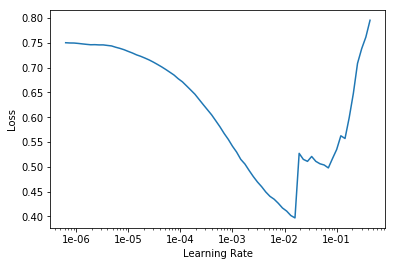

In [29]:
learner.recorder.plot()

In [30]:
learner.fit_one_cycle(2, max_lr=slice(1e-5, 5e-4), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.046906,0.042532,0.983065,24:54
1,0.032987,0.036107,0.982066,29:35


In [31]:
learner.save('head')
learner.load('head')

Learner(data=TextClasDataBunch;

Train: LabelList (127656 items)
x: TextList
[CLS] grandma terri should burn in trash grandma terri is trash . i hate grandma terri . f % % k her to hell ! 71 . 74 . 76 . 40 [SEP],[CLS] , 9 may 2009 ( utc ) it would be easiest if you were to admit to being a member of the involved portuguese lodge , and then there would be no requirement to acknowledge whether you had a previous account ( carlos bot ##el ##ho did not have a good record ) or not and i would then remove the sock ##pu ##ppet template as irrelevant . w ##p : co ##i permits people to edit those articles , such as ms ##ja ##pan does , but just means you have to be more careful in ensuring that references back your edit ##s and that np ##ov is upheld . 20 : 29 [SEP],[CLS] " the object ##ivity of this discussion is doubtful ( non - existent ) ( 1 ) as indicated earlier , the section on marxist leaders ’ views is misleading : ( a ) it lays un ##war ##rant ##ed and excessive emphasis on tr ##ots #

Now, we will unfreeze last two last layers and train the model again

In [32]:
learner.freeze_to(-2)
learner.fit_one_cycle(2, max_lr=slice(1e-5, 5e-4), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.033311,0.038518,0.980818,18:30
1,0.029888,0.037146,0.982213,17:40


In [33]:
learner.save('head-2')
learner.load('head-2')

Learner(data=TextClasDataBunch;

Train: LabelList (127656 items)
x: TextList
[CLS] grandma terri should burn in trash grandma terri is trash . i hate grandma terri . f % % k her to hell ! 71 . 74 . 76 . 40 [SEP],[CLS] , 9 may 2009 ( utc ) it would be easiest if you were to admit to being a member of the involved portuguese lodge , and then there would be no requirement to acknowledge whether you had a previous account ( carlos bot ##el ##ho did not have a good record ) or not and i would then remove the sock ##pu ##ppet template as irrelevant . w ##p : co ##i permits people to edit those articles , such as ms ##ja ##pan does , but just means you have to be more careful in ensuring that references back your edit ##s and that np ##ov is upheld . 20 : 29 [SEP],[CLS] " the object ##ivity of this discussion is doubtful ( non - existent ) ( 1 ) as indicated earlier , the section on marxist leaders ’ views is misleading : ( a ) it lays un ##war ##rant ##ed and excessive emphasis on tr ##ots #

We will now unfreeze the entire model and train it

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06


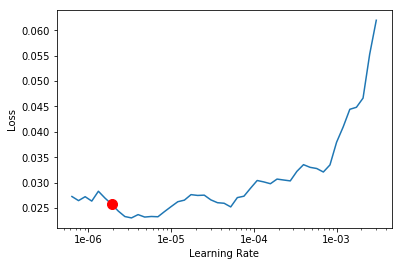

In [34]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [35]:
learner.fit_one_cycle(2, slice(5e-6, 5e-5), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.031048,0.037301,0.980604,25:57
1,0.028199,0.038580,0.982683,28:36


We will now see our model's prediction power

In [36]:
text = 'you are so sweet'
learner.predict(text)

(MultiCategory ,
 tensor([0., 0., 0., 0., 0., 0.]),
 tensor([1.1777e-04, 2.4234e-05, 1.0298e-04, 9.0122e-06, 3.9043e-05, 1.2749e-05]))

In [37]:
text = 'you are pathetic piece of shit'
learner.predict(text)

(MultiCategory toxic;obscene;insult,
 tensor([1., 0., 1., 0., 1., 0.]),
 tensor([9.9793e-01, 1.6227e-01, 9.8385e-01, 7.9275e-05, 9.7258e-01, 7.4961e-03]))

This is awesome!

With few number of epochs, we are able to get the accuracy of around 98% on this multi-label classification task.

Now, lets see how does Fastai ULMFiT fare on this task

# Fastai - ULMFiT

This will have two parts:

1. Training the Language Model
2. Training the Classifier Model

## Language Model


Important thing to remember in the Language Model is that we train it without label. The basic objective by training language model is to predict the next sentence / words in a sequence of text.

In [38]:
src_lm = ItemLists(path, TextList.from_df(train, path=".", cols = "comment_text"), 
                   TextList.from_df(val, path=".", cols = 'comment_text'))

In [39]:
data_lm = src_lm.label_for_lm().databunch(bs=32)

In [40]:
data_lm.show_batch()

idx,text
0,"there would be no requirement to acknowledge whether you had a previous account ( xxmaj carlos xxmaj xxunk did not have a good record ) or not and i would then remove the sockpuppet template as irrelevant . xxup wp : xxup coi permits people to edit those articles , such as msjapan does , but just means you have to be more careful in ensuring that references back your"
1,"xxmaj so it 's an obsession . xxmaj what 's your point ? xxmaj what are your obsessions doing in article space ? : that is not a good reason to revert one 's edits . xxmaj additionally , the deaths of xxmaj xxunk 's companions are not listed alphabetically , but also not listed by who was born first , which is why i switched the positioning of the"
2,"wiki raid threads and ruining fun , dick faggot \n thanks for watching wiki raid threads and ruining fun , dick faggot \n thanks for watching wiki raid threads and ruining fun , dick faggot \n thanks for watching wiki raid threads and ruining fun , dick faggot \n thanks for watching wiki raid threads and ruining fun , dick faggot \n thanks for watching"
3,"xxmaj not every hex code has an exact name . xxmaj it 's probably just called "" "" blue "" "" . xxunk "" xxbos i 'm satisfied with your conclusions ( and also that , even though you do n't say anything clearly , i can see what might be your opinion about this xxup ip ) and i will no longer make sockpuppetry accusations in edit summaries ."
4,""" moving parts "" "" : xxmaj there are devices that contain keys and switches and xxunk , all of them sporting moving ( or movable ) parts and the devices are regarded solid - state nevertheless . 217.237.149.206 "" xxbos i have explained the importance and have described exactly what xxmaj willard xxmaj wonky xxmaj candy - xxmaj hand xxmaj candy is , and request that you keep it"


In [41]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, model_dir="/temp/model")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02


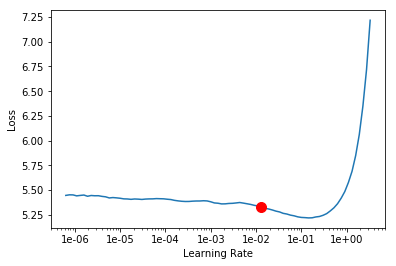

In [42]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [43]:
learn.fit_one_cycle(1, max_lr=slice(5e-4, 5e-3), moms=(0.8, 0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,4.183220,3.954616,0.318500,11:19


In [44]:
learn.save('fit_head')
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (127656 items)
x: LMTextList
xxbos xxmaj grandma xxmaj terri xxmaj should xxmaj burn in xxmaj trash 
  xxmaj grandma xxmaj terri is trash . i hate xxmaj grandma xxmaj terri . xxup xxunk her to xxup hell ! 71.74.76.40,xxbos , 9 xxmaj may 2009 ( xxup utc ) 
  xxmaj it would be easiest if you were to admit to being a member of the involved xxmaj portuguese xxmaj lodge , and then there would be no requirement to acknowledge whether you had a previous account ( xxmaj carlos xxmaj xxunk did not have a good record ) or not and i would then remove the sockpuppet template as irrelevant . xxup wp : xxup coi permits people to edit those articles , such as msjapan does , but just means you have to be more careful in ensuring that references back your edits and that xxup npov is upheld . 20:29,xxbos " 
 
  xxmaj the xxmaj objectivity of this xxmaj discussion is doubtful ( non - existent ) 
 
  ( 1 ) xxmaj as indicated earlier , the section on 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


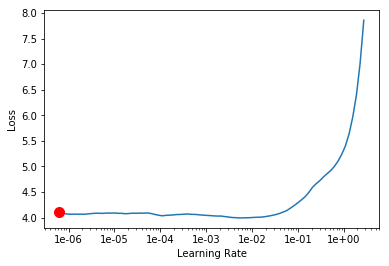

In [45]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [46]:
learn.fit_one_cycle(10, max_lr = slice(1e-4, 1e-3), moms=(0.8, 0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4,  1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.793664,3.787050,0.336729,12:44
1,3.745116,3.693457,0.351849,12:44
2,3.606362,3.643294,0.359943,12:45
3,3.598700,3.610803,0.364181,13:01
4,3.553363,3.590075,0.367450,12:54
5,3.545811,3.575722,0.369594,12:54
6,3.452046,3.567434,0.370651,12:55
7,3.460718,3.562857,0.371756,12:54
8,3.403893,3.560997,0.372018,12:55
9,3.412446,3.560777,0.372056,12:55


In [47]:
learn.save('fine-tuned')
learn.load('fine-tuned')
learn.save_encoder('fine-tuned')

In [48]:
TEXT = "He is a piece of"
N_WORDS = 10
N_SENTENCES = 2

In [49]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

He is a piece of shit . He is a gay . He
He is a piece of shit . He is not a Nazi .


# Classification Model

In [50]:
src_clas = ItemLists(path, TextList.from_df( train, path=".", cols="comment_text", vocab = data_lm.vocab),
                    TextList.from_df( val, path=".", cols="comment_text", vocab = data_lm.vocab))

In [51]:
data_clas = src_clas.label_from_df(cols=label_cols).databunch(bs=32)

In [52]:
data_clas.show_batch()

text,target
xxbos xxmaj take that ! \n \n xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in,toxic;severe_toxic;obscene
"xxbos "" \n \n xxmaj from xxmaj norway ; xxmaj denmark ; xxmaj iceland ; xxmaj scotland ; xxunk etc . ) ; xxmaj wales ; xxmaj ireland ; xxmaj basques & xxmaj xxunk data ) \n \n by xxmaj gunnar xxmaj thompson \n \n "" "" xxmaj on xxunk 's map , the northwestern continent is called "" "" xxmaj xxunk . "" "" xxmaj this",
"xxbos "" \n \n xxmaj definitely his views contradict the current principles of xxmaj wikipedia . i do n't think his intention is to comply with them . xxmaj if no one expresses dissatisfaction and advocates change , there would be no improvement . \n \n xxmaj on the other hand there are users who are abusing the system covertly , like user xxmaj zoe and user xxmaj",
"xxbos "" xxmaj february 2009 ( xxup utc ) \n \n xxmaj well , hope the floor did n't hurt . xxmaj but your characterization of my attitude and what i respect and do n't is to say the least dubious . xxmaj did it occur to you that i did n't attend your schools , have different experiences , different parents , and can think for myself ?",
"xxbos "" again , little of that is relevant , whether true or not , including the ridiculous allegation of a "" "" tantrum "" "" ( whatever the size ) . personal talk is to be avoided on article talk pages , so i wo n't comment further on your "" "" degree "" "" issues . i encourage you though , if you 've time , to consider",


In [53]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, model_dir='/temp/model', metrics=acc_02, loss_func=loss_func)
learn.load_encoder('fine-tuned')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02


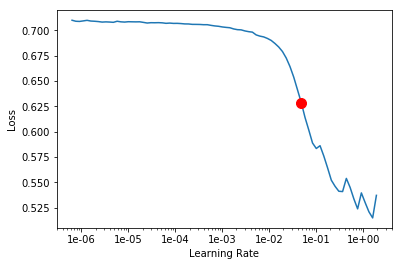

In [54]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [58]:
learn.fit_one_cycle(2, max_lr=slice(1e-3, 1e-2), moms=(0.8, 0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.083538,0.066938,0.968161,05:18
1,0.072916,0.065506,0.970056,04:26


In [59]:
learn.save('first-head')
learn.load('first-head')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (127656 items)
x: TextList
xxbos xxmaj grandma xxmaj terri xxmaj should xxmaj burn in xxmaj trash 
  xxmaj grandma xxmaj terri is trash . i hate xxmaj grandma xxmaj terri . xxup xxunk her to xxup hell ! 71.74.76.40,xxbos , 9 xxmaj may 2009 ( xxup utc ) 
  xxmaj it would be easiest if you were to admit to being a member of the involved xxmaj portuguese xxmaj lodge , and then there would be no requirement to acknowledge whether you had a previous account ( xxmaj carlos xxmaj xxunk did not have a good record ) or not and i would then remove the sockpuppet template as irrelevant . xxup wp : xxup coi permits people to edit those articles , such as msjapan does , but just means you have to be more careful in ensuring that references back your edits and that xxup npov is upheld . 20:29,xxbos " 
 
  xxmaj the xxmaj objectivity of this xxmaj discussion is doubtful ( non - existent ) 
 
  ( 1 ) xxmaj as indicated earlier , the section on xxmaj

In [60]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.067746,0.889934,0.975555,05:52
1,0.058668,1.353945,0.971554,05:02


In [61]:
learn.save('second')
learn.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (127656 items)
x: TextList
xxbos xxmaj grandma xxmaj terri xxmaj should xxmaj burn in xxmaj trash 
  xxmaj grandma xxmaj terri is trash . i hate xxmaj grandma xxmaj terri . xxup xxunk her to xxup hell ! 71.74.76.40,xxbos , 9 xxmaj may 2009 ( xxup utc ) 
  xxmaj it would be easiest if you were to admit to being a member of the involved xxmaj portuguese xxmaj lodge , and then there would be no requirement to acknowledge whether you had a previous account ( xxmaj carlos xxmaj xxunk did not have a good record ) or not and i would then remove the sockpuppet template as irrelevant . xxup wp : xxup coi permits people to edit those articles , such as msjapan does , but just means you have to be more careful in ensuring that references back your edits and that xxup npov is upheld . 20:29,xxbos " 
 
  xxmaj the xxmaj objectivity of this xxmaj discussion is doubtful ( non - existent ) 
 
  ( 1 ) xxmaj as indicated earlier , the section on xxmaj

In [62]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.078076,15.911341,0.956583,08:46
1,0.063021,0.530898,0.965607,08:56


In [63]:
learn.save('third')
learn.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (127656 items)
x: TextList
xxbos xxmaj grandma xxmaj terri xxmaj should xxmaj burn in xxmaj trash 
  xxmaj grandma xxmaj terri is trash . i hate xxmaj grandma xxmaj terri . xxup xxunk her to xxup hell ! 71.74.76.40,xxbos , 9 xxmaj may 2009 ( xxup utc ) 
  xxmaj it would be easiest if you were to admit to being a member of the involved xxmaj portuguese xxmaj lodge , and then there would be no requirement to acknowledge whether you had a previous account ( xxmaj carlos xxmaj xxunk did not have a good record ) or not and i would then remove the sockpuppet template as irrelevant . xxup wp : xxup coi permits people to edit those articles , such as msjapan does , but just means you have to be more careful in ensuring that references back your edits and that xxup npov is upheld . 20:29,xxbos " 
 
  xxmaj the xxmaj objectivity of this xxmaj discussion is doubtful ( non - existent ) 
 
  ( 1 ) xxmaj as indicated earlier , the section on xxmaj

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


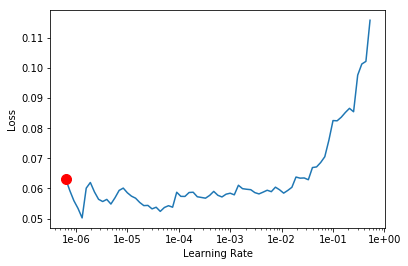

In [64]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [65]:
learn.fit_one_cycle(2, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.058955,0.455071,0.971549,10:35
1,0.053523,0.454931,0.972103,10:12


In [66]:
learn.predict('she is so sweet')

(MultiCategory ,
 tensor([0., 0., 0., 0., 0., 0.]),
 tensor([0.4081, 0.0108, 0.0850, 0.0199, 0.1322, 0.0290]))

In [67]:
learn.predict('you are son of a bitch ')

(MultiCategory toxic;severe_toxic;obscene;insult,
 tensor([1., 1., 1., 0., 1., 0.]),
 tensor([0.9990, 0.7699, 0.9998, 0.0061, 0.9787, 0.1059]))